In [4]:
import rasterio
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt


In [5]:
file_path = "/Users/lb962/Library/CloudStorage/OneDrive-UniversityofCambridge/Vh_log10.tif"
## Now plot the reprojected data
#with rasterio.open(file_path) as src:
   # fig, ax = plt.subplots(figsize=(10, 10))
   # ax.imshow(src.read(1), cmap='gray')  # Plot the first band
   # ax.axis('off')  # Hide the axes
   # plt.show()

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 29248, 'height': 21796, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983041575492327e-05, 0.0, 99.43437,
       0.0, -8.98320792806019e-05, 14.16526)}


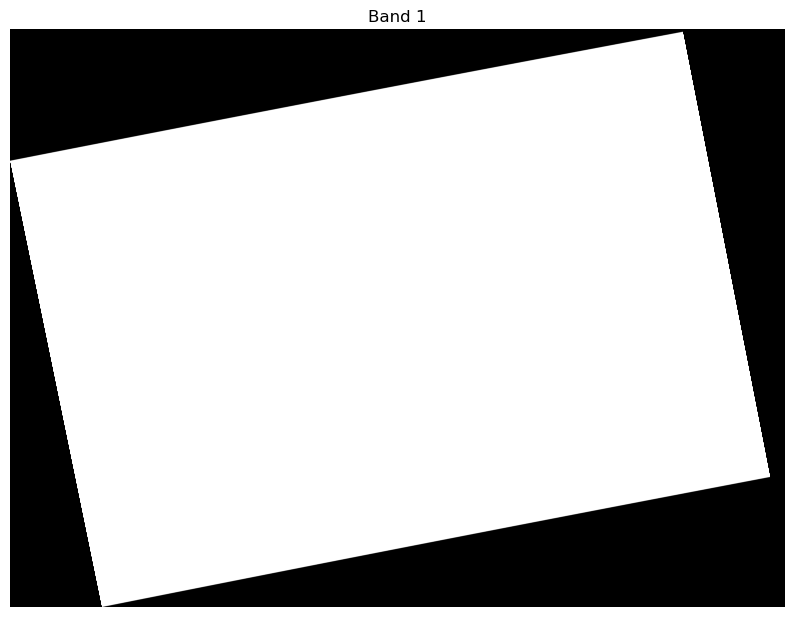

In [6]:
# Open the raster file outside of the 'with' block to keep it open
src = rasterio.open(file_path)

# Print metadata to check the number of bands
print(src.meta)

# Get the transform and CRS from the metadata
transform = src.transform  # Affine transform

# Get the number of bands
num_bands = src.count

data = src.read(1)

# Create a figure to hold the subplots
if num_bands == 1:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(src.read(1), cmap='gray')  # Plot the single band
    ax.set_title('Band 1')
    ax.axis('off')  # Hide the axes

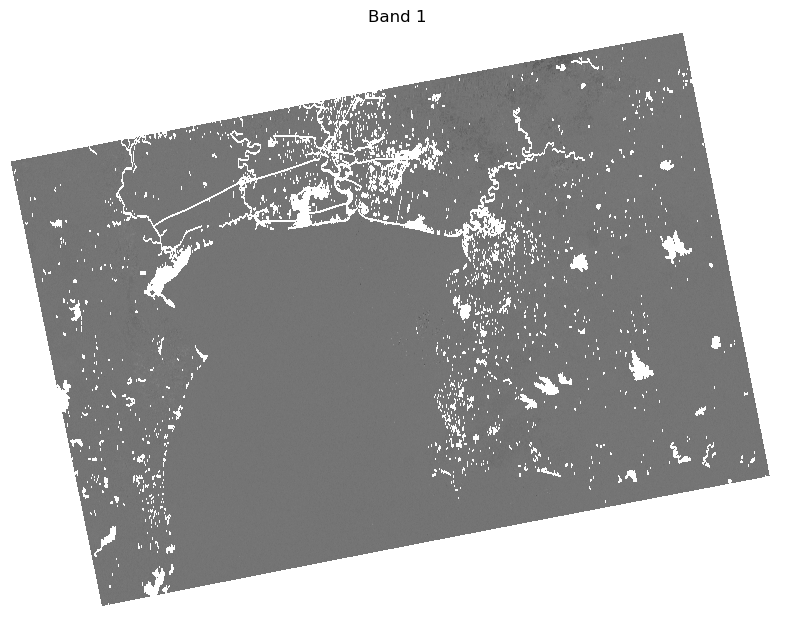

In [14]:
# Get the no-data value from the raster metadata (if available)
nodata_value = src.nodata

# Replace no-data value with NaN
if nodata_value is not None:
    data = np.where(data == nodata_value, np.nan, data)

# Find the minima and maxima of the data (ignoring NaNs)
min_value = np.nanmin(data)
max_value = np.nanmax(data)

# Print the minima and maxima values
#print(f"Min value: {min_value}")
#print(f"Max value: {max_value}")

# Plot the image, ignoring NaNs
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(data, cmap='gray')  # Plot the data, now with NaNs removed
ax.set_title('Band 1')
ax.axis('off')  # Hide the axes
plt.show()

In [8]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.features import geometry_mask
import cartopy.crs as ccrs
import cartopy.feature as cfeature

transform=src.transform
height, width = src.height, src.width

# Define the extent of the raster (bounding box)
lon_min, lat_max = transform * (0, 0)  # top-left corner
lon_max, lat_min = transform * (width, height)  # bottom-right corner
extent = [lon_min, lon_max, lat_min, lat_max]

# Load the shapefile
shapefile_path = '/Users/lb962/Documents/GitHub/MyanmarEQ2025/traffy_processing/traffy_data_2/thailand-latest-free.shp/gis_osm_water_a_free_1.shx'
gdf = gpd.read_file(shapefile_path)

In [ ]:
#src = rasterio.open(file_path)

In [15]:
from rasterio.mask import mask

gdf = gdf.to_crs(src.crs)

# Step 3: Convert the geometries from the GDF to the format required by rasterio (list of dicts)
geoms = [geom.__geo_interface__ for geom in gdf.geometry]

mask = geometry_mask(geoms, transform=src.transform, invert=True, out_shape=src.shape)
# Step 5: Apply the mask to the raster data, setting values inside polygons to zero
data[mask] = np.nan

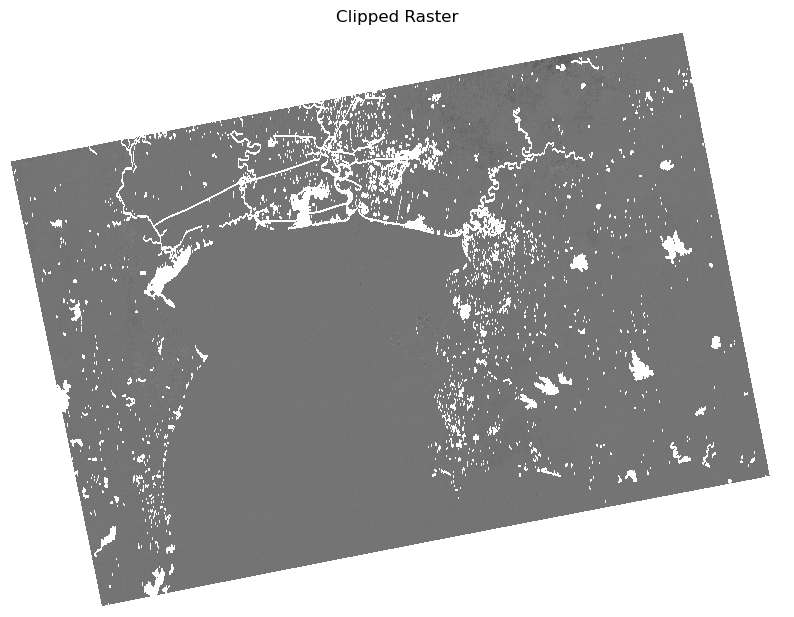

In [16]:
# Step 5: Plot the image, ignoring NaNs
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(data, cmap='gray')  # Plot the first band of the clipped image
ax.set_title('Clipped Raster')
ax.axis('off')  # Hide the axes
plt.show()

In [17]:
dewatered_data = data

In [18]:
thai_bound = "/Users/lb962/Documents/GitHub/MyanmarEQ2025/stat_analysis/data/tha_admbnda_adm0_rtsd_20190221 2/tha_admbnda_adm0_rtsd_20190221.shp"

gdf_bound = gpd.read_file(thai_bound)
gdf_bound = gdf_bound.to_crs(src.crs)

# Step 3: Convert the geometries from the GDF to the format required by rasterio (list of dicts)
geoms_bound = [geom.__geo_interface__ for geom in gdf_bound .geometry]
mask = geometry_mask(geoms_bound, transform=src.transform, invert=False, out_shape=src.shape)
# Step 5: Apply the mask to the raster data, setting values inside polygons to zero
dewatered_data[mask] = np.nan

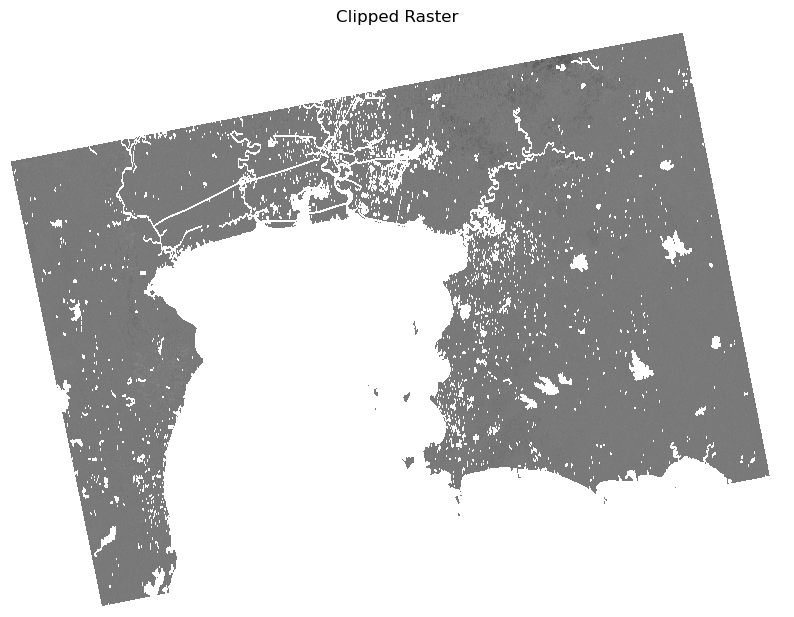

In [19]:
# Step 5: Plot the image, ignoring NaNs
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(dewatered_data, cmap='gray')  # Plot the first band of the clipped image
ax.set_title('Clipped Raster')
ax.axis('off')  # Hide the axes
plt.show()

In [20]:
# Take the absolute value of the dewatered_data
dewatered_data_abs = np.abs(dewatered_data)

In [21]:
from cv2 import bilateralFilter
from scipy.ndimage import median_filter

filtered_data = median_filter(dewatered_data_abs, size=3)

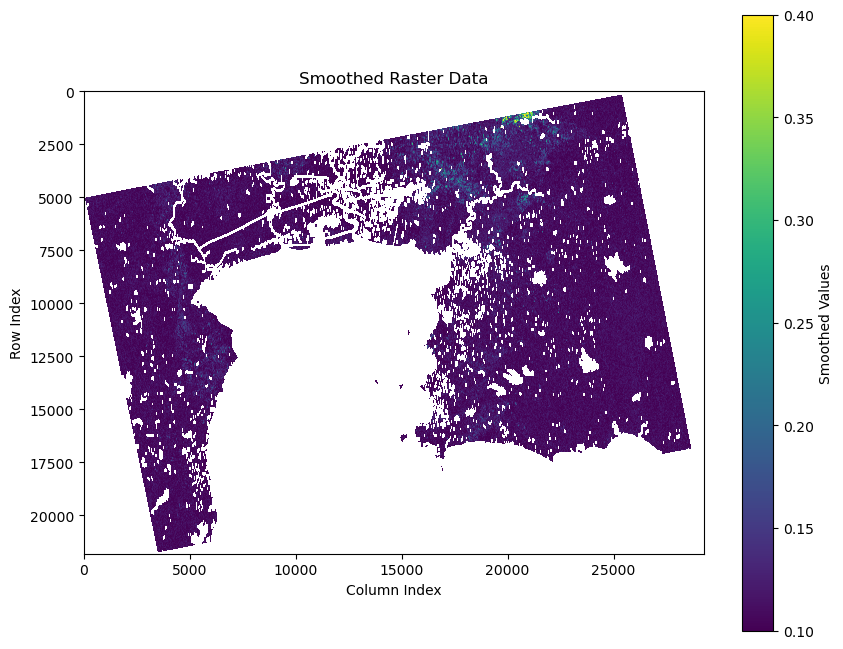

In [50]:
if filtered_data.ndim == 2:
    # Plot the smoothed data
    plt.figure(figsize=(10, 8))
    plt.imshow(smoothed_data, cmap='viridis', origin='upper', vmin = 0.1, vmax = 0.4)
    plt.colorbar(label='Smoothed Values')
    plt.title('Smoothed Raster Data')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

In [23]:
from scipy.ndimage import gaussian_filter, laplace, label
sigma = 1  # Small sigma for preserving small structures
sigma_for_smoothing = 3 # Larger sigma for general smoothing
laplacian_strength = 2  # Strength of Laplacian edge detection
edge_threshold = 0.3  # Lower threshold to catch small edges
min_structure_size = 2  # Minimum size of the structure to keep (in pixels)

In [ ]:
# Apply Gaussian smoothing to reduce noise
smoothed_data = gaussian_filter(filtered_data, sigma=sigma_for_smoothing)

In [95]:

# Apply Laplacian edge detection
edges = laplace(smoothed_data)

# Create a mask for significant edges
edge_mask = np.abs(edges) > edge_threshold  # Mask where Laplacian is significant

# Label connected components (find small structures in the mask)
labeled, num_labels = label(edge_mask)

# Identify and keep small connected structures
small_structures_mask = np.zeros_like(labeled, dtype=bool)
for i in range(1, num_labels + 1):
    structure_size = np.sum(labeled == i)
    if structure_size <= min_structure_size:
        small_structures_mask[labeled == i] = True  # Keep structures that are small

# Amplify edges only for small structures
stronger_edges = np.zeros_like(edges)
stronger_edges[small_structures_mask] = laplacian_strength * edges[small_structures_mask]

# Combine the smoothed data with the amplified edges to preserve fine details
# Sharpening the image by adding back the stronger edges
sharpened_data = smoothed_data - 0.5 * stronger_edges

# Optional: Apply another small Gaussian filter to fine-tune the result
sharpened_data = gaussian_filter(sharpened_data, sigma=sigma)


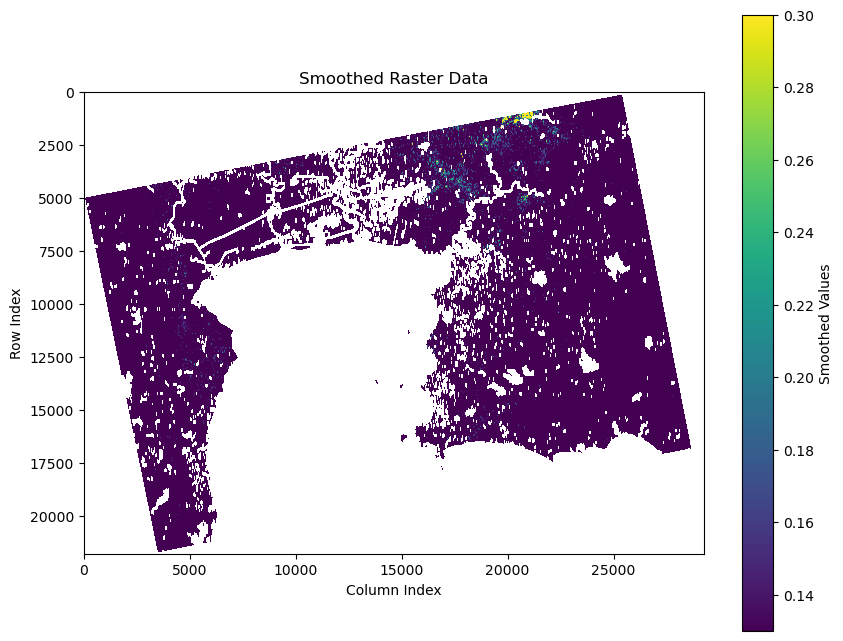

In [96]:
if smoothed_data.ndim == 2:
    # Plot the smoothed data
    plt.figure(figsize=(10, 8))
    plt.imshow(sharpened_data, cmap='viridis', origin='upper',  vmin=0.13, vmax = 0.3)
    plt.colorbar(label='Smoothed Values')
    plt.title('Smoothed Raster Data')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

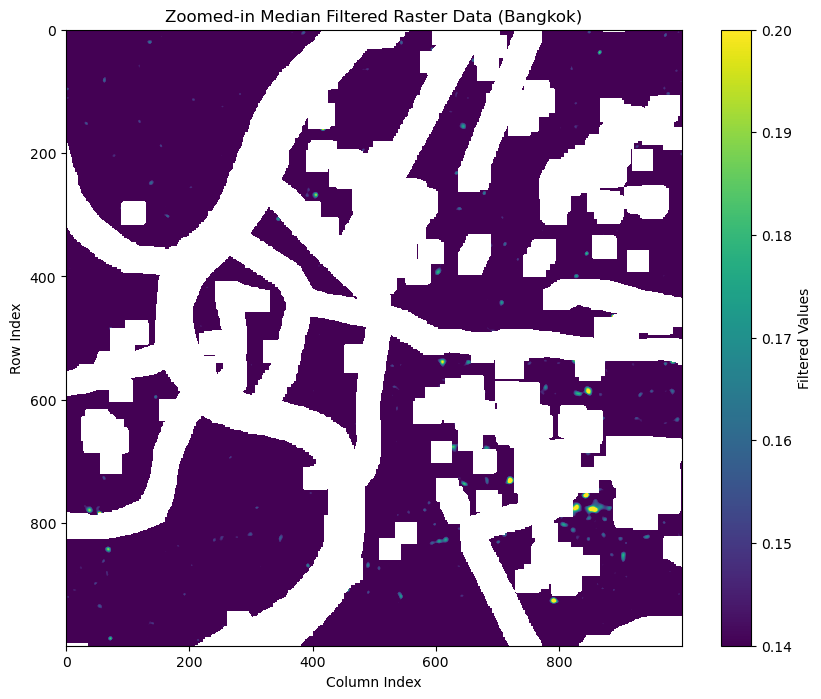

In [101]:
# Define coordinates for Bangkok
lat_bangkok = 13.75
lon_bangkok = 100.5167

# Assuming you have the `src` object for your raster data
# Extract the transformation and the raster's bounding box (extent)
transform = src.transform  # src is your rasterio dataset
width = src.width
height = src.height

# Convert lat/lon to pixel coordinates (row, col)
# In the case of a raster's affine transform, this is done as:
col_bangkok, row_bangkok = ~transform * (lon_bangkok, lat_bangkok)

# Convert to integer coordinates
col_bangkok = int(col_bangkok)
row_bangkok = int(row_bangkok)

# Define the zoom window around Bangkok (you can adjust this size based on how much of the area you want to show)
window_size = 500

# Define the bounds of the zoom window
row_min = max(0, row_bangkok - window_size)
row_max = min(height, row_bangkok + window_size)
col_min = max(0, col_bangkok - window_size)
col_max = min(width, col_bangkok + window_size)

# Slice the zoomed-in data based on the window
#zoomed_data = filtered_data_median[row_min:row_max, col_min:col_max]
zoomed_data = sharpened_data[row_min:row_max, col_min:col_max]

# Plot the zoomed-in data
plt.figure(figsize=(10, 8))
plt.imshow(zoomed_data, cmap='viridis', origin='upper', vmin=0.14, vmax=0.20)
plt.colorbar(label='Filtered Values')
plt.title('Zoomed-in Median Filtered Raster Data (Bangkok)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

# process

In [102]:
processed_data = sharpened_data
# Set values below 0.11 to nan
processed_data[processed_data < 0.14] = np.nan

<Axes: >

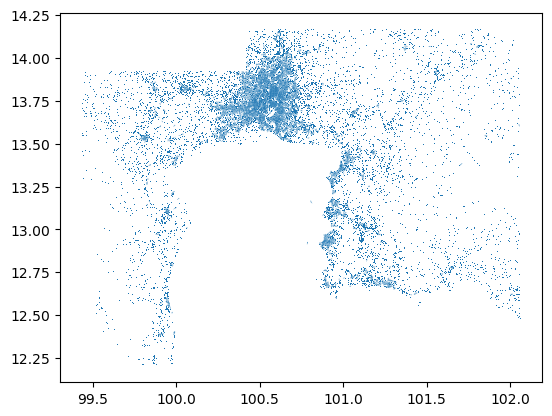

In [ ]:
import rasterio
import geopandas as gpd
from rasterio import features
import numpy as np
from shapely.geometry import shape

file_path = "/Users/lb962/Library/CloudStorage/OneDrive-UniversityofCambridge/01_pair01_bldg_height_clipped.tif"

with rasterio.open(file_path) as building_src:
    # Read the raster data
    building_data = building_src.read(1)  # Assuming we're working with the first band
    # Define a threshold value (adjust according to your needs)
    threshold_value = 0.0  # Only consider values above this threshold
    # Apply threshold (binary mask for pixels above threshold)
    mask = building_data > threshold_value

    # Use rasterio.features.shapes to extract polygons from the mask
    shapes = features.shapes(mask.astype(np.int32), mask=mask, transform=building_src.transform)

    # Convert the shapes to a list of polygons directly into a GeoDataFrame
    polygons = [shape(polygon) for polygon, value in shapes]

# Create a GeoDataFrame directly without a for loop
filled_gdf = gpd.GeoDataFrame(geometry=polygons)

# Set the CRS (Coordinate Reference System) of the GeoDataFrame to match the raster's CRS
filled_gdf.set_crs(building_src.crs, allow_override=True, inplace=True)

# Save the GeoDataFrame to a shapefile or other vector format (optional)
filled_gdf.to_file('output_polygons.shp')

# Optionally: Plot the polygons
filled_gdf.plot()


In [88]:
gdf_building = gpd.read_file('output_polygons.shp')

In [89]:
transform = src.transform

In [103]:
from rasterio.mask import mask
from rasterio.features import geometry_mask

# Ensure the GeoDataFrame has the same CRS as the raster
gdf_building = gdf_building.to_crs(src.crs)

# Convert the geometries to the format required by rasterio (list of dicts)
geoms = [geom.__geo_interface__ for geom in gdf_building.geometry]

# Create a mask where True = Outside the buildings, False = Inside
mask = geometry_mask(geoms, transform=transform , invert=False, out_shape=processed_data.shape)

# Apply the mask:
# - Values inside polygons remain unchanged
# - Values outside polygons are set to zero
processed_data[mask] = 0  # Set outside values to zero

In [93]:
processed_data[mask] = np.nan

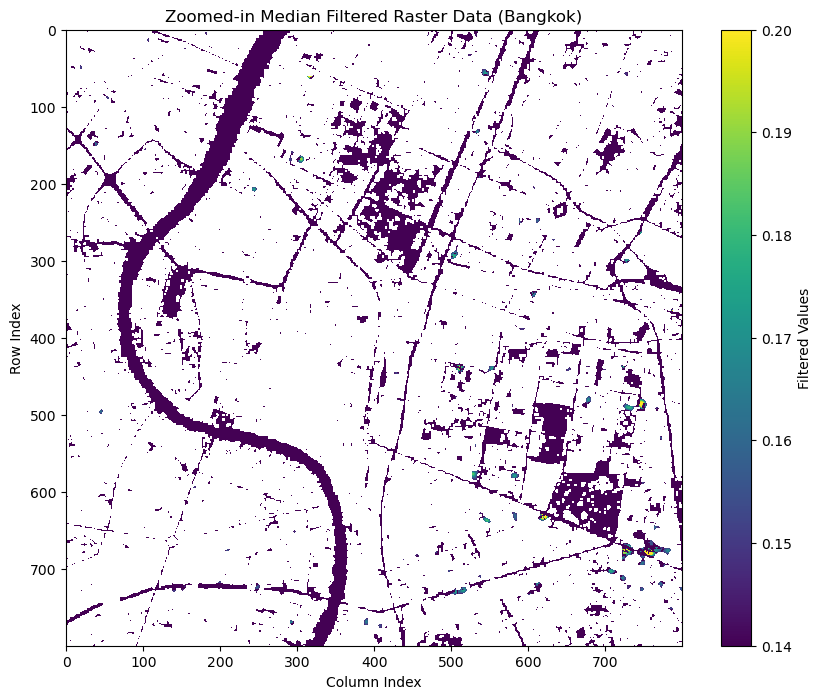

In [105]:
# Define coordinates for Bangkok
lat_bangkok = 13.75
lon_bangkok = 100.5167

# Assuming you have the `src` object for your raster data
# Extract the transformation and the raster's bounding box (extent)
transform = src.transform  # src is your rasterio dataset
width = src.width
height = src.height

# Convert lat/lon to pixel coordinates (row, col)
# In the case of a raster's affine transform, this is done as:
col_bangkok, row_bangkok = ~transform * (lon_bangkok, lat_bangkok)

# Convert to integer coordinates
col_bangkok = int(col_bangkok)
row_bangkok = int(row_bangkok)

# Define the zoom window around Bangkok (you can adjust this size based on how much of the area you want to show)
window_size = 400

# Define the bounds of the zoom window
row_min = max(0, row_bangkok - window_size)
row_max = min(height, row_bangkok + window_size)
col_min = max(0, col_bangkok - window_size)
col_max = min(width, col_bangkok + window_size)

# Slice the zoomed-in data based on the window
#zoomed_data = filtered_data_median[row_min:row_max, col_min:col_max]
zoomed_data = processed_data[row_min:row_max, col_min:col_max]

# Plot the zoomed-in data
plt.figure(figsize=(10, 8))
plt.imshow(zoomed_data, cmap='viridis', origin='upper', vmin=0.14, vmax=0.20)
plt.colorbar(label='Filtered Values')
plt.title('Zoomed-in Median Filtered Raster Data (Bangkok)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

In [106]:
import rasterio

output_path = "processed_buildings.tif"  # Output file name

# Save raster directly
dst = rasterio.open(
    output_path,
    "w",  
    driver="GTiff",
    height=processed_data.shape[0],  
    width=processed_data.shape[1],   
    count=1,  
    dtype=processed_data.dtype,  
   # crs="EPSG:3857",  
    transform=transform,  
    nodata=0  
)
dst.write(processed_data, 1)  
dst.close()  # Close file

print(f"Saved raster: {output_path}")

Saved raster: processed_buildings.tif
